# Classification

## Preparation

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.path import Path
from matplotlib.transforms import offset_copy

np.random.seed(16)

## Generate a Dataset for Classification

In [3]:
def generate_random_points(n_samples, lower_left_point, upper_right_point):
    random_points = []
    for i in range(n_samples):
        dim = upper_right_point - lower_left_point
        random_point = np.random.random(size=(2, 1)) * dim + lower_left_point
        random_point = random_point.flatten().tolist()
        random_points.append(random_point)
    
    return np.asarray(random_points)

In [4]:
def path_in_bbox(point_a, point_b, bbox):
    path = Path(np.append(point_a.T, point_b.T, axis = 0))
    if path.intersects_bbox(bbox):
        return True
    else:
        return False


def point_in_bbox(point, bbox):
    return path_in_bbox(point, point, bbox)


def generate_labels(random_points, bbox, keep_inner_box_free = False):
    inner_bbox = None
    if keep_inner_box_free:
        inner_bbox = Bbox.from_bounds(
            x0 = bbox.x0 + 0.5, 
            y0 = bbox.y0 + bbox.height * 0.25, 
            width = bbox.width * 0.5, 
            height = bbox.height * 0.5
        )

    labels = []
    for random_point in random_points:
        if point_in_bbox(np.asarray(random_point[0:2]).reshape(2,1), bbox):
            if inner_bbox is None:
                labels.append(1)
            else:
                if point_in_bbox(np.asarray(random_point[0:2]).reshape(2,1), inner_bbox):
                    labels.append(np.random.randint(2))
                else:
                    labels.append(1)
        else:
            labels.append(0)
            
    return np.asarray(labels)

In [5]:
def generate_dataset(n=1000, keep_inner_box_free=False):
    bbox = Bbox.from_bounds(x0 = 1, y0 = 1, width = 6, height = 3)
    X = generate_random_points(n, 
                                  np.array([[bbox.x0 - 1, bbox.y0 - 1]]).T, 
                                  np.array([[bbox.x0 + bbox.width + 1, bbox.y0 + bbox.height + 1]]).T)
    y = generate_labels(X, bbox, keep_inner_box_free)
    
    return X, y

In [6]:
def draw_point(ax, point, style='ro'):
    ax.plot(point[0], point[1], style)


def draw_random_points(random_points, labels):
    fig, ax = plt.subplots()
    x_min, x_max = random_points[:, 0].min() - 0.5, random_points[:, 0].max() + 0.5
    y_min, y_max = random_points[:, 1].min() - 0.5, random_points[:, 1].max() + 0.5
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.axis('equal')
    
    # draw random_points
    for point, label in zip(random_points, labels):
        if label == 1:
            draw_point(ax, point, 'ro')
        else:
            draw_point(ax, point, 'bo')

    plt.show()

<IPython.core.display.Javascript object>


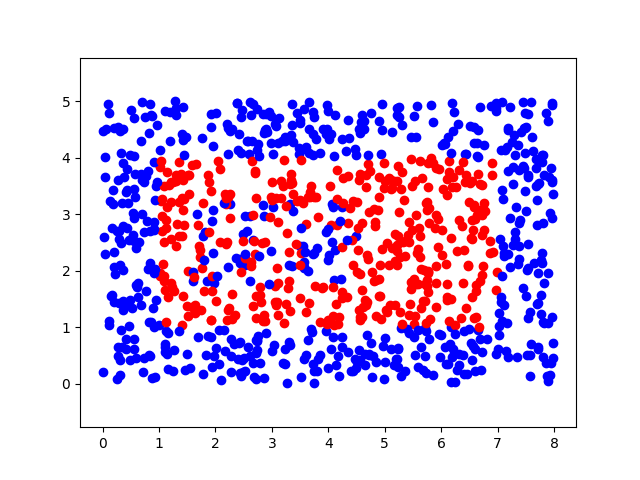

In [7]:
X, y = generate_dataset(n=1000, keep_inner_box_free=True)
draw_random_points(X, y)

## Compare Classifiers

<IPython.core.display.Javascript object>


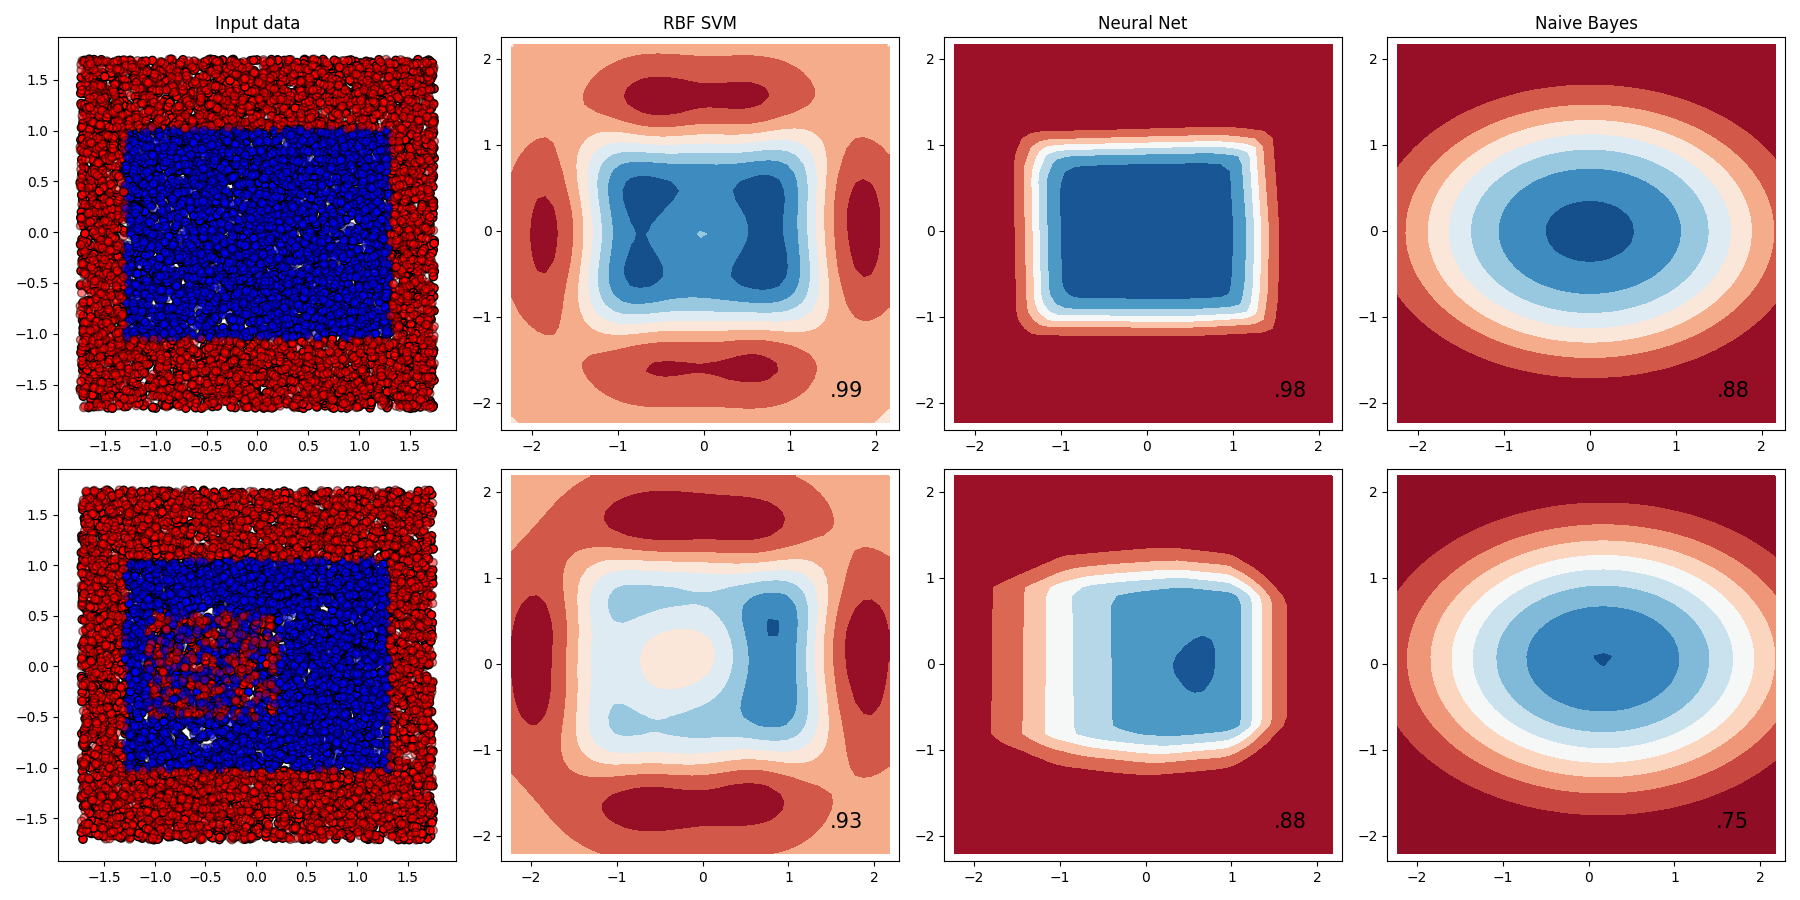

In [8]:
# based on https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

mesh_step_size = .1

names = ["RBF SVM", 
         "Neural Net", 
         "Naive Bayes"]

classifiers = [
    SVC(gamma=2, C=1),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()
]

datasets = [
    generate_dataset(10000),
    generate_dataset(10000, keep_inner_box_free=True)
]

figure = plt.figure(figsize=(18, 9))
subplot_i = 1
# iterate over datasets
for dataset_i, dataset in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = dataset
    X = StandardScaler().fit_transform(X)  # Compute the mean and std, then perform 
                                           # standardization by centering and scaling
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    # create a grid with xv containing the x values and yv containing the y values
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xv, yv = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))

    # just plot the dataset first
    cm = plt.cm.RdBu  # color map red-white-blue
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, subplot_i)  # set of n_datasets x n_classifiers+1 subplots, additional row is for training and test data
    if dataset_i == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.5,  # increase opacity for test points
               edgecolors='k')
    ax.set_xlim(xv.min(), xv.max())
    ax.set_ylim(yv.min(), yv.max())
    ax.axis('equal')
    subplot_i += 1

    # iterate over classifiers
    for name, classifier in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, subplot_i)
        
        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(classifier, "decision_function"):
            # evaluate the decision function for the given samples
            Z = classifier.decision_function(np.c_[xv.ravel(), yv.ravel()])
        else:
            # compute probabilities of possible outcomes for the given samples
            Z = classifier.predict_proba(np.c_[xv.ravel(), yv.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xv.shape)
        ax.contourf(xv, yv, Z, cmap=cm, alpha=1.)

        ax.set_xlim(xv.min(), xv.max())
        ax.set_ylim(yv.min(), yv.max())
        ax.axis('equal')
        if dataset_i == 0:
            ax.set_title(name)
        ax.text(xv.max() - 0.3, yv.min() + 0.3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        subplot_i += 1

plt.tight_layout()
plt.show()

---

# Mixture Models

## Generate Dataset for Mixture Models

In [9]:
def generate_random_points(n_samples, bbox, inner_box_density = 0.5):
    inner_bbox = Bbox.from_bounds(
        x0 = bbox.x0 + 0.5, 
        y0 = bbox.y0 + bbox.height * 0.25, 
        width = bbox.width * 0.5, 
        height = bbox.height * 0.5
    )
    
    random_points = []
    for i in range(n_samples):
        dim = np.array([[bbox.width, bbox.height]]).T
        lower_left_point = np.array([[bbox.x0, bbox.y0]]).T
        random_point = np.random.random(size=(2, 1)) * dim + lower_left_point
        random_point = random_point.flatten().tolist()
        
        if inner_bbox is None:
            random_points.append(random_point)
        else:
            if point_in_bbox(np.asarray(random_point[0:2]).reshape(2,1), inner_bbox):
                if np.random.random_sample() <= inner_box_density:
                    random_points.append(random_point)
            else:
                random_points.append(random_point)
    
    return np.asarray(random_points)

In [10]:
def generate_dataset(n = 1000, inner_box_density = 0.5):
    bbox = Bbox.from_bounds(x0=1, y0=1, width=6, height=3)
    return generate_random_points(n, bbox, inner_box_density)

In [11]:
def draw_random_points(random_points):
    fig, ax = plt.subplots()
    x_min, x_max = random_points[:, 0].min() - 0.5, random_points[:, 0].max() + 0.5
    y_min, y_max = random_points[:, 1].min() - 0.5, random_points[:, 1].max() + 0.5
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.axis('equal')
    
    # draw random_points
    for point in random_points:
        draw_point(ax, point, 'bo')

    plt.show()

<IPython.core.display.Javascript object>


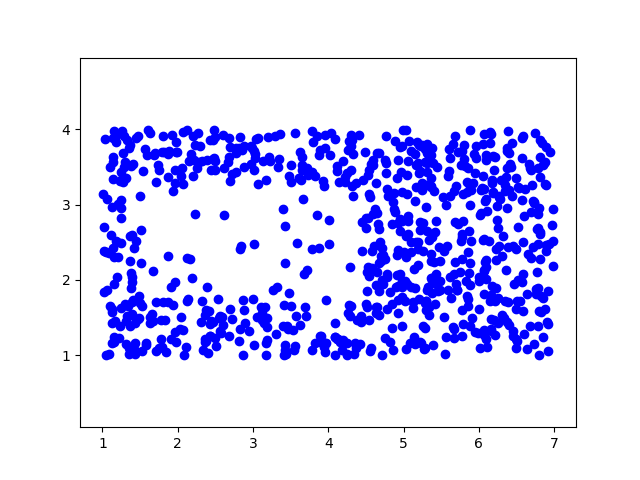

In [12]:
X = generate_dataset(inner_box_density = 0.2)
draw_random_points(X)

## Compare Mixture Modeling Algorithms

<IPython.core.display.Javascript object>


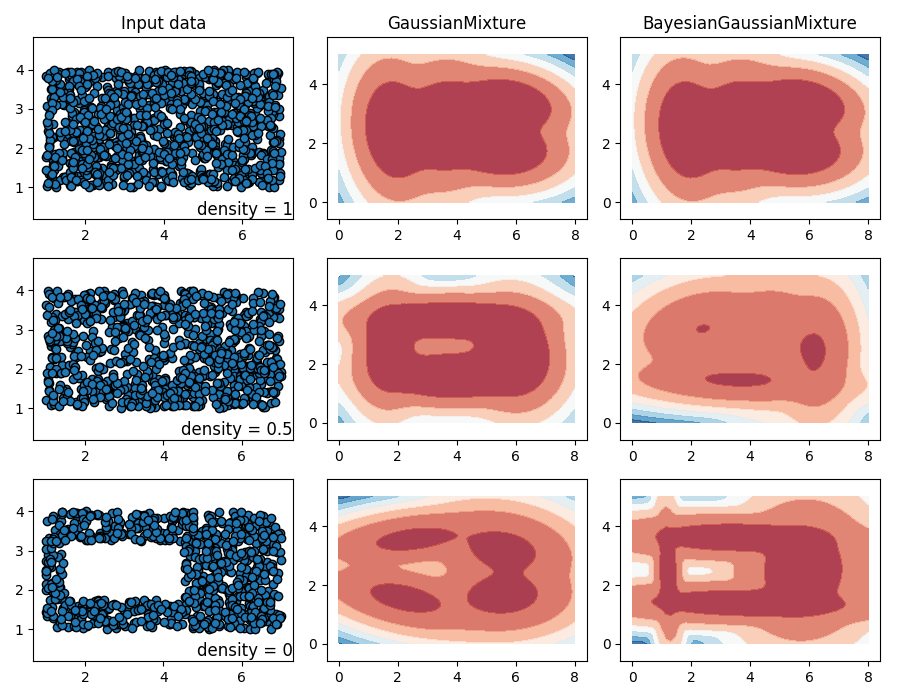

In [13]:
# based on https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

np.random.seed(0)

names = ["GaussianMixture",
         "BayesianGaussianMixture"]

classifiers = [
    mixture.GaussianMixture(n_components=4, covariance_type='full'),
    mixture.BayesianGaussianMixture(n_components=4, covariance_type='full')
]

datasets = {
    "density = 1": generate_dataset(n = 1000, inner_box_density = 1.),
    "density = 0.5": generate_dataset(n = 1000, inner_box_density = 0.5),
    "density = 0": generate_dataset(n = 1000, inner_box_density = 0.),
}

figure = plt.figure(figsize=(9, 7))
subplot_i = 1
# iterate over datasets
for dataset_i, (dataset_name, dataset) in enumerate(datasets.items()):
    X_train = dataset

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    x = np.linspace(x_min, x_max)
    y = np.linspace(y_min, y_max)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T

    # just plot the dataset first
    cm = plt.cm.RdBu  # color map red-white-blue
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, subplot_i)  # set of n_datasets x n_classifiers+1 subplots, additional row is for training and test data
    if dataset_i == 0:
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], cmap=cm_bright, edgecolors='k')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.axis('equal')
    ax.text(x.max() - 0.7, y.min() + 0.3, ('%s' % dataset_name).lstrip('0'), size=12, horizontalalignment='right')

    subplot_i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, subplot_i)
        
        clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
        clf.fit(X_train)

        Z = -clf.score_samples(XX)
        Z = Z.reshape(X.shape)
    
        ax.contourf(X, Y, Z, cmap=plt.cm.RdBu, alpha=0.8)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        ax.axis('equal')
        if dataset_i == 0:
            ax.set_title(name)
        subplot_i += 1

plt.tight_layout()
plt.show()

## Add Additional Input Feature

In [14]:
def generate_random_points(n_samples, bbox):
    inner_bbox = Bbox.from_bounds(
        x0 = bbox.x0 + 1, 
        y0 = bbox.y0 + 1, 
        width = bbox.width - 2.5, 
        height = bbox.height - 2
    )
    
    random_points = []
    for i in range(n_samples):
        dim = np.array([[bbox.width, bbox.height]]).T
        lower_left_point = np.array([[bbox.x0, bbox.y0]]).T
        random_point = np.random.random(size=(2, 1)) * dim + lower_left_point
        random_point = random_point.flatten().tolist()
        
        p = np.random.random_sample()
        if point_in_bbox(np.asarray(random_point[0:2]).reshape(2,1), inner_bbox):
            if np.random.random_sample() > p:
                random_points.append(random_point + [p])
        else:
            random_points.append(random_point + [p])
    
    return np.asarray(random_points)

In [15]:
def generate_dataset(n=1000):
    bbox = Bbox.from_bounds(x0 = 1, y0 = 1, width = 4, height = 4)
    return generate_random_points(n, bbox)

<IPython.core.display.Javascript object>


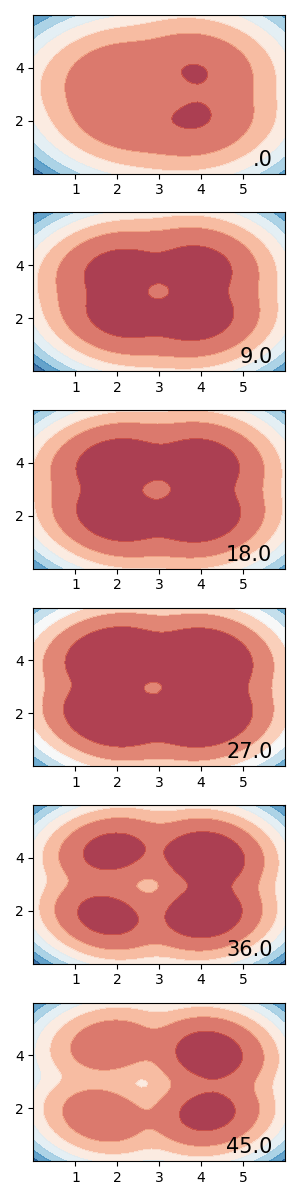

In [16]:
np.random.seed(0)

X_train = generate_dataset(10000)

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
p_min, p_max = X_train[:, 2].min() - 1, X_train[:, 2].max() + 1
x = np.linspace(x_min, x_max)
y = np.linspace(y_min, y_max)
p = np.linspace(p_min, p_max)

X, Y, P = np.meshgrid(x, y, p)

XX = np.array([X.ravel(), Y.ravel(), P.ravel()]).T

clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(X_train)

Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

figure = plt.figure(figsize=(3, 12))
subplot_i = 1
for i in range(0, 50, 9):
    ax = plt.subplot(6, 1, subplot_i)
    ax.contourf(X[:, :, i], Y[:, :, i], Z[:, :, i], cmap=plt.cm.RdBu, alpha=0.8)
    ax.text(x.max() - 0.3, y.min() + 0.3, ('%.1f' % i).lstrip('0'), size=15, horizontalalignment='right')
    
    subplot_i += 1

plt.tight_layout()
plt.show()

## Plot as Grid

1.8680705288913104e-14
0.15908611821333532


<IPython.core.display.Javascript object>


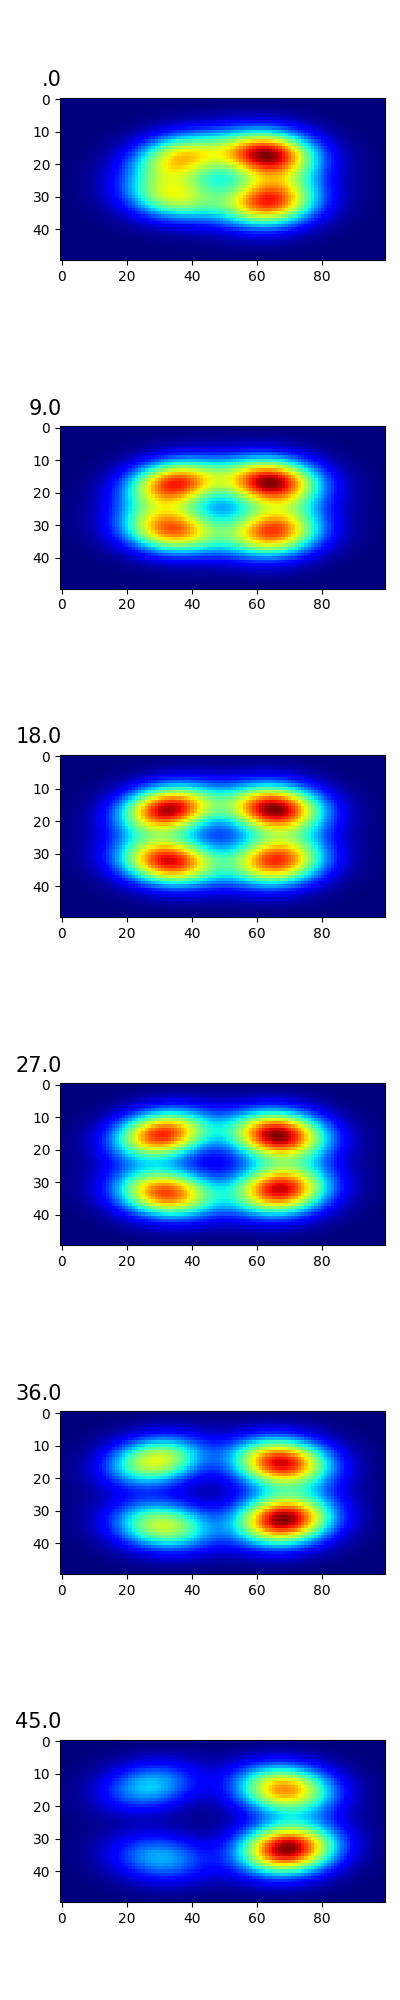

In [22]:
np.random.seed(0)

X_train = generate_dataset(10000)

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
p_min, p_max = X_train[:, 2].min() - 1, X_train[:, 2].max() + 1
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 50)
p = np.linspace(p_min, p_max)

X, Y, P = np.meshgrid(x, y, p)

XX = np.array([X.ravel(), Y.ravel(), P.ravel()]).T

clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(X_train)

Z = clf.score_samples(XX)  # weighted log probabilities for each sample
Z = Z.reshape(X.shape)
Z = np.exp(Z)
print(Z.min())
print(Z.max())

figure = plt.figure(figsize=(4, 20))
subplot_i = 1
for i in range(0, 50, 9):
    ax = plt.subplot(6, 1, subplot_i)
    cax = ax.imshow(Z[:, :, i], cmap='jet');
    ax.text(0, -4, ('%.1f' % i).lstrip('0'), size=15, horizontalalignment='right')
    
    subplot_i += 1
    
plt.tight_layout()
plt.show()